In [191]:
import pandas as pd
import matplotlib as mpl
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math


import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [192]:
df = pd.read_csv('csv_session2.csv')

In [193]:
df

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,24/02/2016 15:53:00,NaN,NaN,85.0,72.0
1,24/02/2016 15:54:00,61441.0,61441.0,90.0,123.0
2,24/02/2016 15:55:00,153.0,51.0,91.0,153.0
3,24/02/2016 15:56:00,153.0,48.0,92.0,136.0
4,24/02/2016 15:57:00,153.0,46.0,NaN,NaN
...,...,...,...,...,...
6839,29/02/2016 09:52:00,NaN,NaN,NaN,NaN
6840,29/02/2016 09:53:00,NaN,NaN,NaN,NaN
6841,29/02/2016 09:54:00,NaN,NaN,NaN,NaN
6842,29/02/2016 09:55:00,NaN,NaN,NaN,NaN


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Timestamp (GMT)             6844 non-null   object 
 1   Lifetouch Heart Rate        4388 non-null   float64
 2   Lifetouch Respiration Rate  4388 non-null   float64
 3   Oximeter SpO2               4352 non-null   float64
 4   Oximeter Pulse              4352 non-null   float64
dtypes: float64(4), object(1)
memory usage: 267.5+ KB


In [195]:
df['Timestamp (GMT)'] = pd.to_datetime(df['Timestamp (GMT)'], infer_datetime_format=True)

In [196]:
df = df.dropna()

In [197]:
df=  df.loc[df['Lifetouch Heart Rate'] <= 200]
df=  df.loc[df['Oximeter SpO2'] >= 40]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f50bbd499d0>,
      dtype=object)

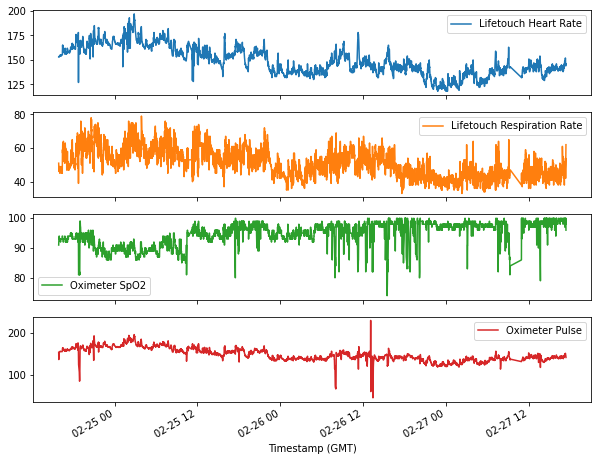

In [198]:
#df.set_index('date')[['Appliances', 'lights','T_out', 'RH_1', 'Visibility']].plot(subplots=True)
df.set_index('Timestamp (GMT)')[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate','Oximeter SpO2', 'Oximeter Pulse']].plot(subplots=True)

In [199]:
df_input=df[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate','Oximeter SpO2', 'Oximeter Pulse']]

In [200]:
df_input

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
2,153.0,51.0,91.0,153.0
3,153.0,48.0,92.0,136.0
6,153.0,46.0,94.0,153.0
7,153.0,49.0,94.0,154.0
8,154.0,48.0,93.0,154.0
...,...,...,...,...
4406,149.0,54.0,100.0,149.0
4407,147.0,42.0,99.0,147.0
4408,144.0,53.0,98.0,146.0
4409,144.0,57.0,100.0,145.0


In [201]:
df_input.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,4074.000000,4074.000000,4074.000000,4074.000000
mean,148.998773,51.338488,94.647275,147.913844
std,14.771199,8.394903,3.919336,16.057492
min,118.000000,33.000000,74.000000,44.000000
25%,138.000000,45.000000,93.000000,137.000000
50%,146.000000,51.000000,96.000000,145.000000
75%,161.000000,57.000000,98.000000,160.000000
max,197.000000,79.000000,100.000000,230.000000


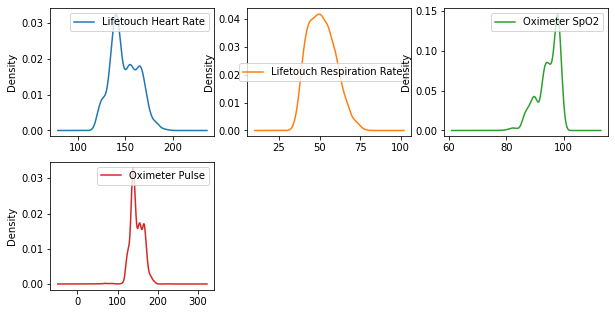

In [202]:
df_input.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()

In [203]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_input)

In [204]:
data_scaled

array([[0.44303797, 0.39130435, 0.65384615, 0.58602151],
       [0.44303797, 0.32608696, 0.69230769, 0.49462366],
       [0.44303797, 0.2826087 , 0.76923077, 0.58602151],
       ...,
       [0.32911392, 0.43478261, 0.92307692, 0.5483871 ],
       [0.32911392, 0.52173913, 1.        , 0.54301075],
       [0.35443038, 0.63043478, 0.84615385, 0.52150538]])

In [205]:
features=data_scaled
target=data_scaled[:,0]

In [206]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.44303797, 0.39130435, 0.65384615, 0.58602151],
         [0.44303797, 0.32608696, 0.69230769, 0.49462366]]]),
 array([0.44303797]))

In [207]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)

In [208]:
x_train.shape

(3259, 4)

In [209]:
x_test.shape

(815, 4)

In [210]:
win_length=45
batch_size=11
num_features=4
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [211]:
train_generator[0]

(array([[[0.44303797, 0.39130435, 0.65384615, 0.58602151],
         [0.44303797, 0.32608696, 0.69230769, 0.49462366],
         [0.44303797, 0.2826087 , 0.76923077, 0.58602151],
         ...,
         [0.50632911, 0.45652174, 0.73076923, 0.61827957],
         [0.51898734, 0.47826087, 0.73076923, 0.61827957],
         [0.50632911, 0.45652174, 0.73076923, 0.61827957]],
 
        [[0.44303797, 0.32608696, 0.69230769, 0.49462366],
         [0.44303797, 0.2826087 , 0.76923077, 0.58602151],
         [0.44303797, 0.34782609, 0.76923077, 0.59139785],
         ...,
         [0.51898734, 0.47826087, 0.73076923, 0.61827957],
         [0.50632911, 0.45652174, 0.73076923, 0.61827957],
         [0.50632911, 0.47826087, 0.73076923, 0.61290323]],
 
        [[0.44303797, 0.2826087 , 0.76923077, 0.58602151],
         [0.44303797, 0.34782609, 0.76923077, 0.59139785],
         [0.4556962 , 0.32608696, 0.73076923, 0.59139785],
         ...,
         [0.50632911, 0.45652174, 0.73076923, 0.61827957],
        

In [212]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.9)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.9)) 
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=METRICS)

In [213]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 45, 128)           68096     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 45, 128)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 45, 128)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
________________________________________________

In [214]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])



Epoch 1/50
293/293 [==============================] - 6s 11ms/step - loss: 0.0459 - mean_absolute_error: 0.1569 - val_loss: 0.0258 - val_mean_absolute_error: 0.1453
Epoch 2/50
293/293 [==============================] - 2s 8ms/step - loss: 0.0254 - mean_absolute_error: 0.1207 - val_loss: 0.0181 - val_mean_absolute_error: 0.1194
Epoch 3/50
293/293 [==============================] - 2s 8ms/step - loss: 0.0197 - mean_absolute_error: 0.1074 - val_loss: 0.0161 - val_mean_absolute_error: 0.1123
Epoch 4/50
293/293 [==============================] - 2s 8ms/step - loss: 0.0169 - mean_absolute_error: 0.1011 - val_loss: 0.0147 - val_mean_absolute_error: 0.1067
Epoch 5/50
293/293 [==============================] - 2s 8ms/step - loss: 0.0151 - mean_absolute_error: 0.0943 - val_loss: 0.0058 - val_mean_absolute_error: 0.0633
Epoch 6/50
293/293 [==============================] - 2s 8ms/step - loss: 0.0133 - mean_absolute_error: 0.0899 - val_loss: 0.0078 - val_mean_absolute_error: 0.0749
Epoch 7/50
293/

In [215]:
model.evaluate_generator(test_generator, verbose=0)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0024011374916881323, 0.037903424352407455]

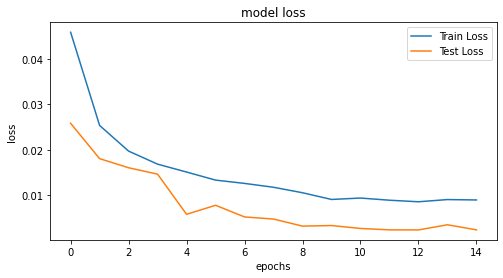

In [216]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [217]:
predictions=model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [218]:
predictions.shape[0]

770

In [219]:
predictions

array([[0.2102592 ],
       [0.19465685],
       [0.1791505 ],
       [0.16470405],
       [0.15302572],
       [0.14530481],
       [0.13818954],
       [0.13493311],
       [0.1332402 ],
       [0.13435578],
       [0.13490611],
       [0.13525657],
       [0.13436347],
       [0.13618019],
       [0.14143938],
       [0.14802182],
       [0.15139894],
       [0.1517806 ],
       [0.1511902 ],
       [0.15069552],
       [0.15163486],
       [0.15612353],
       [0.16700785],
       [0.1781087 ],
       [0.18968815],
       [0.19719575],
       [0.20155126],
       [0.19823039],
       [0.19384542],
       [0.19228262],
       [0.19713743],
       [0.20188066],
       [0.20622396],
       [0.20600739],
       [0.204204  ],
       [0.20143308],
       [0.19620448],
       [0.18878742],
       [0.18658666],
       [0.1869251 ],
       [0.19321114],
       [0.20204282],
       [0.20507164],
       [0.20533526],
       [0.20822251],
       [0.20846395],
       [0.21286547],
       [0.219

In [220]:
y_test

array([0.12658228, 0.07594937, 0.08860759, 0.12658228, 0.08860759,
       0.10126582, 0.13924051, 0.11392405, 0.11392405, 0.11392405,
       0.07594937, 0.05063291, 0.08860759, 0.06329114, 0.10126582,
       0.10126582, 0.07594937, 0.07594937, 0.05063291, 0.03797468,
       0.06329114, 0.06329114, 0.06329114, 0.05063291, 0.03797468,
       0.06329114, 0.03797468, 0.06329114, 0.02531646, 0.03797468,
       0.03797468, 0.03797468, 0.02531646, 0.01265823, 0.01265823,
       0.01265823, 0.07594937, 0.10126582, 0.11392405, 0.26582278,
       0.2278481 , 0.17721519, 0.2278481 , 0.18987342, 0.10126582,
       0.08860759, 0.11392405, 0.10126582, 0.10126582, 0.11392405,
       0.07594937, 0.11392405, 0.10126582, 0.11392405, 0.08860759,
       0.10126582, 0.08860759, 0.11392405, 0.13924051, 0.12658228,
       0.10126582, 0.10126582, 0.10126582, 0.10126582, 0.11392405,
       0.15189873, 0.21518987, 0.20253165, 0.2278481 , 0.20253165,
       0.18987342, 0.15189873, 0.17721519, 0.20253165, 0.24050

In [221]:
x_test

array([[0.12658228, 0.17391304, 0.88461538, 0.4516129 ],
       [0.07594937, 0.13043478, 0.88461538, 0.44623656],
       [0.08860759, 0.10869565, 0.92307692, 0.44086022],
       ...,
       [0.32911392, 0.43478261, 0.92307692, 0.5483871 ],
       [0.32911392, 0.52173913, 1.        , 0.54301075],
       [0.35443038, 0.63043478, 0.84615385, 0.52150538]])

In [222]:
x_test[:,1:][win_length:]

array([[0.10869565, 0.88461538, 0.44623656],
       [0.17391304, 0.88461538, 0.44086022],
       [0.2173913 , 0.84615385, 0.44086022],
       ...,
       [0.43478261, 0.92307692, 0.5483871 ],
       [0.52173913, 1.        , 0.54301075],
       [0.63043478, 0.84615385, 0.52150538]])

In [223]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [224]:
df_pred

,0,0,1,2
0,0.210259,0.108696,0.884615,0.446237
1,0.194657,0.173913,0.884615,0.440860
2,0.179151,0.217391,0.846154,0.440860
3,0.164704,0.152174,0.884615,0.440860
4,0.153026,0.239130,0.884615,0.435484
...,...,...,...,...
765,0.309028,0.456522,1.000000,0.564516
766,0.310634,0.195652,0.961538,0.553763
767,0.311048,0.434783,0.923077,0.548387
768,0.305640,0.521739,1.000000,0.543011


In [225]:
rev_trans=scaler.inverse_transform(df_pred)

In [226]:
rev_trans

array([[134.61047673,  38.        ,  97.        , 127.        ],
       [133.37789106,  41.        ,  97.        , 126.        ],
       [132.15289004,  43.        ,  96.        , 126.        ],
       ...,
       [142.57282504,  53.        ,  98.        , 146.        ],
       [142.14559391,  57.        , 100.        , 145.        ],
       [141.38868082,  62.        ,  96.        , 141.        ]])

In [227]:
df_final=df_input[predictions.shape[0]*-1:]

In [228]:
df_final.count()

Lifetouch Heart Rate          770
Lifetouch Respiration Rate    770
Oximeter SpO2                 770
Oximeter Pulse                770
dtype: int64

In [229]:
df_final['Predicted Heart Rate']=rev_trans[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [230]:
df_final

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Predicted Heart Rate
3492,125.0,38.0,97.0,127.0,134.610477
3493,127.0,41.0,97.0,126.0,133.377891
3494,126.0,43.0,96.0,126.0,132.152890
3495,126.0,40.0,97.0,126.0,131.011620
3496,127.0,44.0,97.0,125.0,130.089032
...,...,...,...,...,...
4406,149.0,54.0,100.0,149.0,142.413228
4407,147.0,42.0,99.0,147.0,142.540101
4408,144.0,53.0,98.0,146.0,142.572825
4409,144.0,57.0,100.0,145.0,142.145594


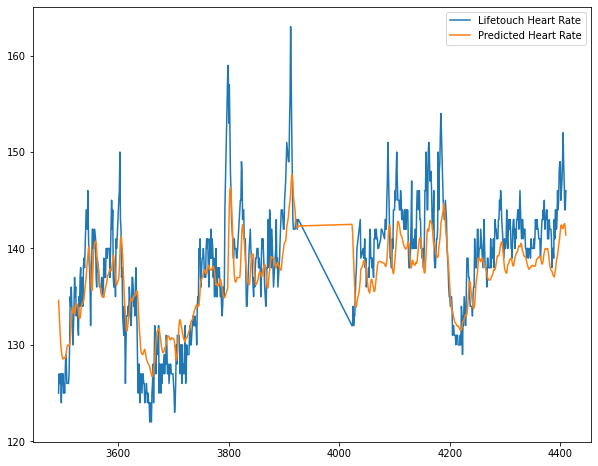

In [231]:
df_final[['Lifetouch Heart Rate','Predicted Heart Rate']].plot()

In [232]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
expected = df_final['Lifetouch Heart Rate']
predictions = df_final['Predicted Heart Rate']
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)


RMSE: 3.871111


In [233]:
mae = mean_absolute_error(expected, predictions)
print('MAE: %f' % mae)

#These error values are in the original units of the predicted values. 
#A mean absolute error of zero indicates no error.

MAE: 2.994370
